# MovieMind - Model Training & Evaluation

This notebook trains and evaluates ML models for:
1. Sentiment Classification (positive/neutral/negative)
2. Score Prediction (0-10 scale)
3. Clustering Analysis
4. Statistical Analysis

In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from src.utils.db_manager import DatabaseManager
from src.preprocessing.text_processor import TextProcessor
from src.models.sentiment_classifier import SentimentClassifier
from src.models.score_predictor import ScorePredictor
from src.models.clustering import MovieClusterer

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load Data

In [2]:
# Load reviews with movie metadata
with DatabaseManager() as db:
    query = """
    SELECT
        r.review_id,
        r.content,
        r.rating,
        r.text_length,
        r.word_count,
        m.title,
        m.genres,
        m.vote_average,
        m.runtime
    FROM reviews r
    JOIN movies m ON r.movie_id = m.movie_id
    WHERE r.content IS NOT NULL
    LIMIT 5000
    """
    
    reviews = db.execute_query(query)

df = pd.DataFrame(reviews)
print(f"Loaded {len(df)} reviews")
df.head()

INFO:src.utils.db_manager:Database connection established


INFO:src.utils.db_manager:Database connection closed


Loaded 269 reviews


,review_id,content,rating,text_length,word_count,title,genres,vote_average,runtime
0,3,FULL SPOILER-FREE REVIEW @ https://movieswetex...,8.0,1006,146,Zootopia 2,"[Animation, Comedy, Adventure, Family, Mystery]",7.6,107
1,4,Very short: Zootopia 2 is lovely and has as ma...,9.0,2002,348,Zootopia 2,"[Animation, Comedy, Adventure, Family, Mystery]",7.6,107
2,5,Things are not looking so hot for this animal ...,7.0,1633,272,Zootopia 2,"[Animation, Comedy, Adventure, Family, Mystery]",7.6,107
3,6,# A well-made live-action adaptation\r\n\r\nTh...,10.0,2168,384,Omniscient Reader: The Prophecy,"[Action, Adventure, Fantasy]",6.7,117
4,248,It's like reading a comic book and watching a ...,None,84,15,Spider-Man: Into the Spider-Verse,"[Animation, Action, Adventure, Science Fiction]",8.4,117


## 2. Text Preprocessing

In [3]:
# Initialize text processor
processor = TextProcessor()

# Clean reviews
print("Preprocessing text...")
df['cleaned_content'] = df['content'].apply(
    lambda x: processor.clean_text(x) if pd.notna(x) else ""
)

# Show example
print("\n=== Original Review ===")
print(df['content'].iloc[0][:500])

print("\n=== Cleaned Review ===")
print(df['cleaned_content'].iloc[0][:500])

Preprocessing text...

=== Original Review ===
FULL SPOILER-FREE REVIEW @ https://movieswetextedabout.com/zootopia-2-movie-review-disney-proves-it-can-still-make-sequels-with-soul-and-purpose/

Rating: A-

"Zootopia 2 asserts itself as a worthy and even necessary sequel, overcoming the natural loss of the novelty factor with a narrative that dares to dig deeper into the imperfect foundations of its utopia.

Although the mystery doesn't reach the suspenseful peaks of its predecessor, the film makes up for it with dazzling visual evoluti

=== Cleaned Review ===
full spoiler free review rating a zootopia 2 asserts itself as a worthy and even necessary sequel overcoming the natural loss of the novelty factor with a narrative that dares to dig deeper into the imperfect foundations of its utopia although the mystery doesn t reach the suspenseful peaks of its predecessor the film makes up for it with dazzling visual evolution a voice cast in a state of grace and a mature exploration of the pa

In [4]:
# Prepare target variable
df['score'] = df['rating'].fillna(df['vote_average'])
df_labeled = df[df['score'].notna()].copy()

print(f"Reviews with scores: {len(df_labeled)}")
print(f"\nScore distribution:")
print(df_labeled['score'].describe())

Reviews with scores: 269

Score distribution:
count     269
unique     23
top       7.0
freq       54
Name: score, dtype: object


## 3. Sentiment Classification

Sentiment distribution:
sentiment
positive    216
negative     27
neutral      26
Name: count, dtype: int64


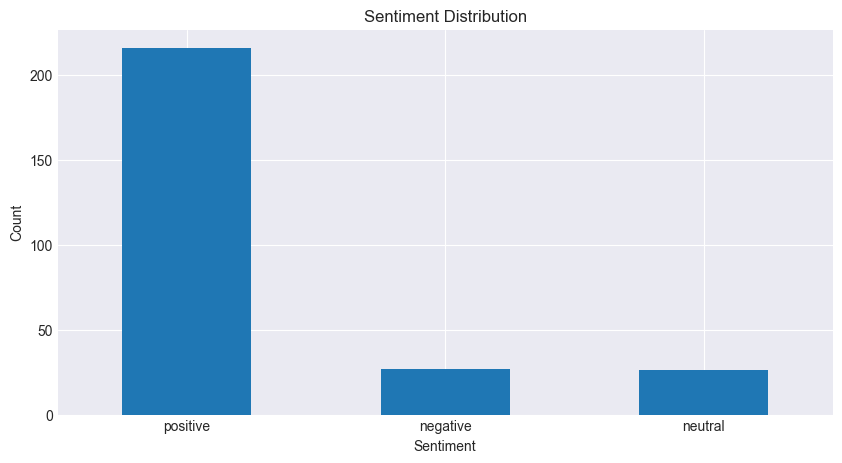

In [5]:
# Create sentiment labels
classifier = SentimentClassifier(model_type='logistic', max_features=5000)

df_labeled['sentiment'] = classifier.prepare_sentiment_labels(
    df_labeled['score'],
    threshold_pos=7.0,
    threshold_neg=5.0
)

# Check distribution
print("Sentiment distribution:")
print(df_labeled['sentiment'].value_counts())

# Visualize
plt.figure(figsize=(10, 5))
df_labeled['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_labeled['cleaned_content'],
    df_labeled['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df_labeled['sentiment']
)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 215
Test size: 54


In [7]:
# Train classifier
print("Training sentiment classifier...")
train_metrics = classifier.train(X_train, y_train, validation_split=0.2)

print("\nTraining metrics:")
for key, value in train_metrics.items():
    print(f"  {key}: {value}")

INFO:src.models.sentiment_classifier:Training logistic sentiment classifier...


INFO:src.models.sentiment_classifier:Fitting TF-IDF vectorizer...


Training sentiment classifier...


INFO:src.models.sentiment_classifier:Training model...


INFO:src.models.sentiment_classifier:Training accuracy: 0.9942


INFO:src.models.sentiment_classifier:Validation accuracy: 0.7907



Training metrics:
  train_accuracy: 0.9941860465116279
  train_samples: 172
  n_features: 5000
  val_accuracy: 0.7906976744186046
  val_samples: 43


In [8]:
# Evaluate on test set
test_metrics = classifier.evaluate(X_test, y_test)

INFO:src.models.sentiment_classifier:Evaluating sentiment classifier...


INFO:src.models.sentiment_classifier:Test Accuracy: 0.7963


INFO:src.models.sentiment_classifier:Test Precision: 0.6461


INFO:src.models.sentiment_classifier:Test Recall: 0.7963


INFO:src.models.sentiment_classifier:Test F1-Score: 0.7133



Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.00      0.00      0.00         5
    positive       0.81      1.00      0.90        43

    accuracy                           0.80        54
   macro avg       0.27      0.33      0.30        54
weighted avg       0.65      0.80      0.71        54


Confusion Matrix:
[[ 0  1  5]
 [ 0  0  5]
 [ 0  0 43]]


<Figure size 800x600 with 0 Axes>

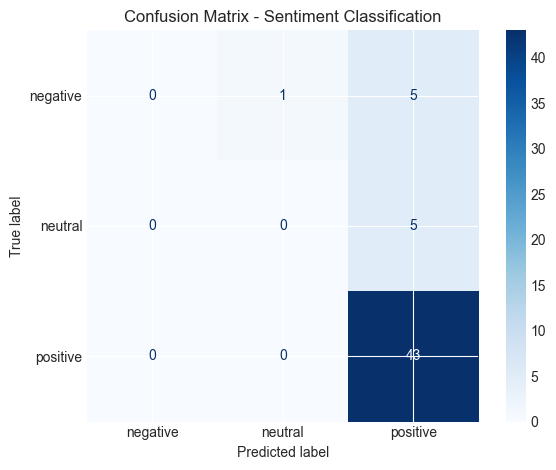

In [9]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=test_metrics['confusion_matrix'],
    display_labels=classifier.model.classes_
)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix - Sentiment Classification')
plt.tight_layout()
plt.show()

In [10]:
# Top features per class
importance = classifier.get_feature_importance(top_n=15)

print("\n=== Top Features Per Sentiment ===")
for class_name, features in importance.items():
    print(f"\n{class_name.upper()}:")
    for feat, score in features[:10]:
        print(f"  {feat:20s}: {score:7.4f}")


=== Top Features Per Sentiment ===

NEGATIVE:
  trash               :  0.7107
  watched             :  0.5686
  mission impossible  :  0.5535
  movie               :  0.5490
  the movie           :  0.5423
  to this             :  0.5235
  mission             :  0.5129
  impossible          :  0.4979
  nothing             :  0.4669
  liked the           :  0.4516

NEUTRAL:
  her                 :  0.6020
  but                 :  0.5450
  new                 :  0.5269
  that                :  0.4964
  hee                 :  0.4886
  on                  :  0.4709
  like                :  0.4695
  noise               :  0.4287
  movie               : -0.4263
  it all              :  0.4069

POSITIVE:
  trash               : -0.6192
  its                 : -0.4776
  that                : -0.4323
  was                 :  0.4218
  or                  : -0.3894
  with                : -0.3881
  great               :  0.3417
  but                 : -0.3405
  only                : -0.3388
  up

## 4. Score Prediction (Regression)

In [11]:
# Prepare metadata features
meta_features = ['text_length', 'word_count']
df_labeled[meta_features] = df_labeled[meta_features].fillna(0)

# Split data
X_text_train, X_text_test, X_meta_train, X_meta_test, y_score_train, y_score_test = train_test_split(
    df_labeled['cleaned_content'],
    df_labeled[meta_features],
    df_labeled['score'],
    test_size=0.2,
    random_state=42
)

print(f"Train size: {len(X_text_train)}")
print(f"Test size: {len(X_text_test)}")

Train size: 215
Test size: 54


In [12]:
# Train score predictor
predictor = ScorePredictor(model_type='ridge', max_features=3000)

print("Training score predictor...")
train_metrics = predictor.train(
    X_text_train,
    y_score_train,
    X_meta_train,
    validation_split=0.2
)

print("\nTraining metrics:")
for key, value in train_metrics.items():
    print(f"  {key}: {value}")

INFO:src.models.score_predictor:Training ridge score predictor...


INFO:src.models.score_predictor:Fitting TF-IDF vectorizer...


INFO:src.models.score_predictor:Scaling metadata features...


INFO:src.models.score_predictor:Training model...


INFO:src.models.score_predictor:Training - RMSE: 0.8241, MAE: 0.5714, R²: 0.7614


INFO:src.models.score_predictor:Validation - RMSE: 1.3173, MAE: 1.0178, R²: 0.3060


Training score predictor...

Training metrics:
  train_rmse: 0.8241419248858333
  train_mae: 0.5714316388432658
  train_r2: 0.7614325288958759
  train_samples: 172
  n_features: 3002
  val_rmse: 1.317330727857155
  val_mae: 1.0178093399878116
  val_r2: 0.30598802264073754
  val_samples: 43


In [13]:
# Evaluate
test_metrics = predictor.evaluate(X_text_test, y_score_test, X_meta_test)

INFO:src.models.score_predictor:Evaluating score predictor...


INFO:src.models.score_predictor:Test RMSE: 1.8985


INFO:src.models.score_predictor:Test MAE: 1.3332


INFO:src.models.score_predictor:Test R²: 0.1835


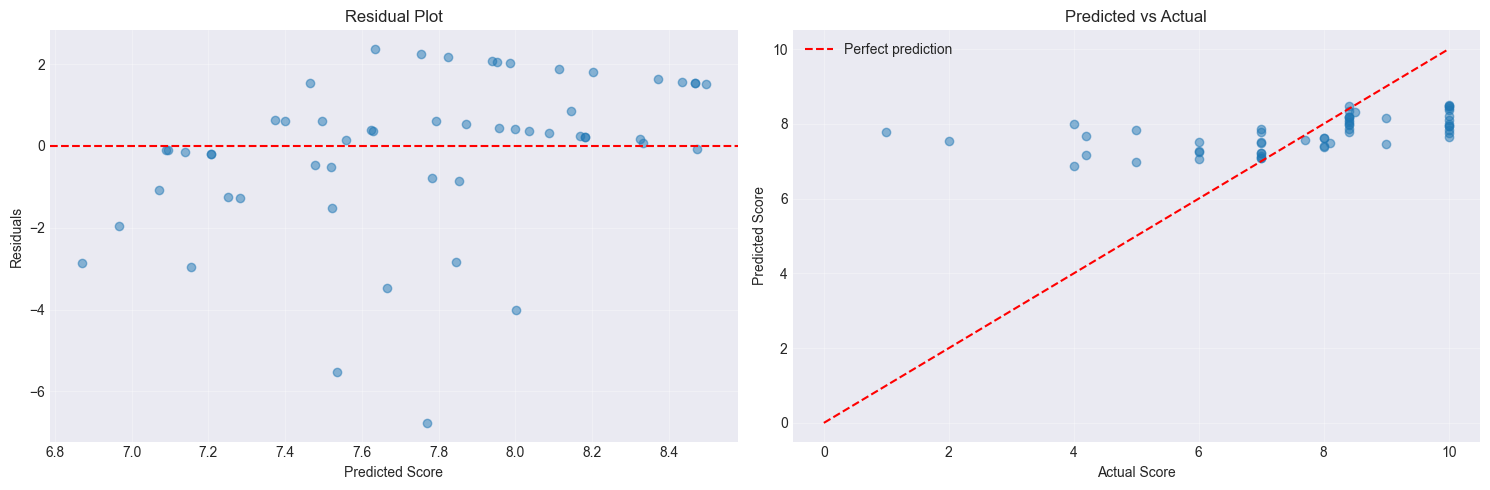

In [14]:
# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual plot
axes[0].scatter(test_metrics['predictions'], test_metrics['residuals'], alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Score')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')
axes[0].grid(True, alpha=0.3)

# Predicted vs Actual
axes[1].scatter(y_score_test, test_metrics['predictions'], alpha=0.5)
axes[1].plot([0, 10], [0, 10], 'r--', label='Perfect prediction')
axes[1].set_xlabel('Actual Score')
axes[1].set_ylabel('Predicted Score')
axes[1].set_title('Predicted vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Top features for regression
importance_reg = predictor.get_feature_importance(top_n=20)

print("\n=== Top Features for Score Prediction ===")
for feat, score in importance_reg[:15]:
    print(f"  {feat:20s}: {score:7.4f}")


=== Top Features for Score Prediction ===
  trash               : -2.2430
  watched             : -1.1218
  there               : -1.0510
  up                  : -1.0455
  movie               :  1.0382
  alien               : -1.0260
  invasion            : -1.0260
  some                : -1.0257
  worst               : -1.0186
  of an               : -1.0152
  one of              :  1.0009
  humans              : -0.9722
  seriously           : -0.9666
  empire              :  0.9459
  use of              : -0.9452


## 5. Clustering Analysis

In [16]:
# Prepare data for clustering
df_cluster = df_labeled.copy()

# Initialize clusterer
clusterer = MovieClusterer(n_clusters=5, random_state=42)

# Prepare features (text + numeric)
features = clusterer.prepare_features(
    df_cluster,
    text_column='cleaned_content',
    numeric_columns=['text_length', 'word_count', 'score']
)

print(f"Feature matrix shape: {features.shape}")

INFO:src.models.clustering:Extracting TF-IDF features from cleaned_content


INFO:src.models.clustering:Scaling numeric features: ['text_length', 'word_count', 'score']


Feature matrix shape: (269, 503)


INFO:src.models.clustering:Performing elbow analysis for k=1 to 10


Performing elbow analysis...



Elbow Analysis Results:


,k,inertia,silhouette
0,1,1031.230437,NaN
1,2,646.061809,0.350734
2,3,499.748027,0.321974
3,4,413.874757,0.285214
4,5,375.497949,0.294085
5,6,342.095398,0.223665
6,7,315.185214,0.207644
7,8,299.766280,0.185236
8,9,287.146500,0.165237
9,10,276.462477,0.164720


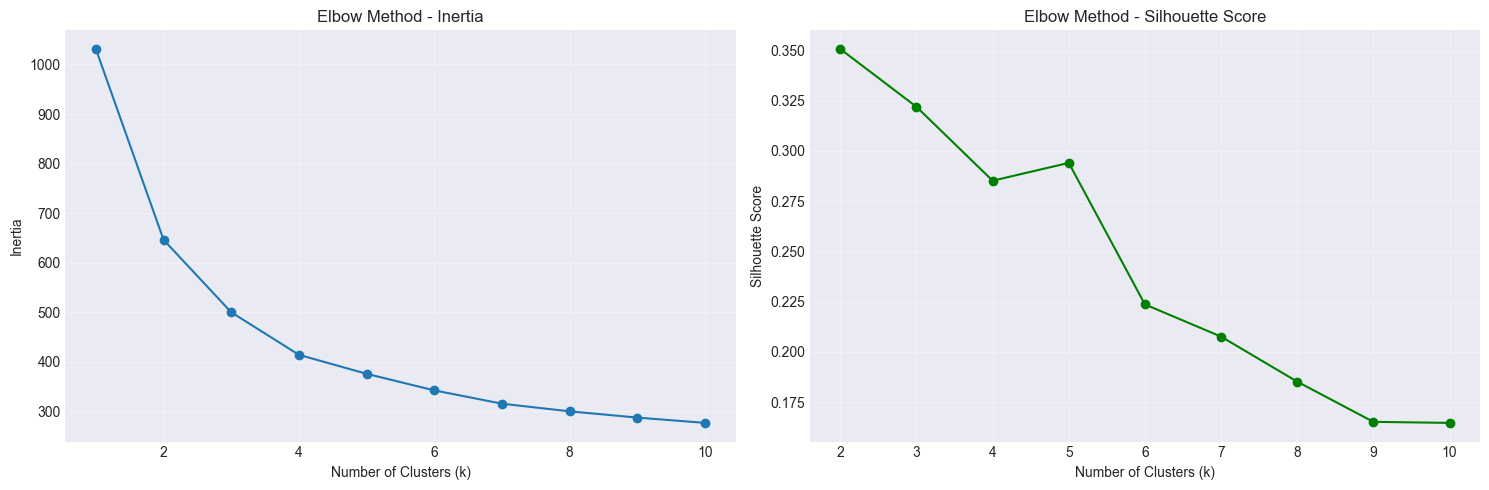

In [17]:
# Elbow analysis
print("Performing elbow analysis...")
elbow_results = clusterer.elbow_analysis(features, max_k=10)

print("\nElbow Analysis Results:")
display(elbow_results)

# Plot
clusterer.plot_elbow(elbow_results)

In [18]:
# Fit clustering with optimal k (adjust based on elbow plot)
optimal_k = 5  # Adjust this based on elbow plot
clusterer = MovieClusterer(n_clusters=optimal_k, random_state=42)

labels, metrics = clusterer.fit_predict(features)

print("\nClustering Metrics:")
print(f"  Silhouette Score: {metrics['silhouette_score']:.4f}")
print(f"  Davies-Bouldin Score: {metrics['davies_bouldin_score']:.4f}")
print(f"  Inertia: {metrics['inertia']:.2f}")

INFO:src.models.clustering:Fitting k-means with 5 clusters


INFO:src.models.clustering:Silhouette Score: 0.2941


INFO:src.models.clustering:Davies-Bouldin Score: 1.1917


INFO:src.models.clustering:Inertia: 375.50



Clustering Metrics:
  Silhouette Score: 0.2941
  Davies-Bouldin Score: 1.1917
  Inertia: 375.50


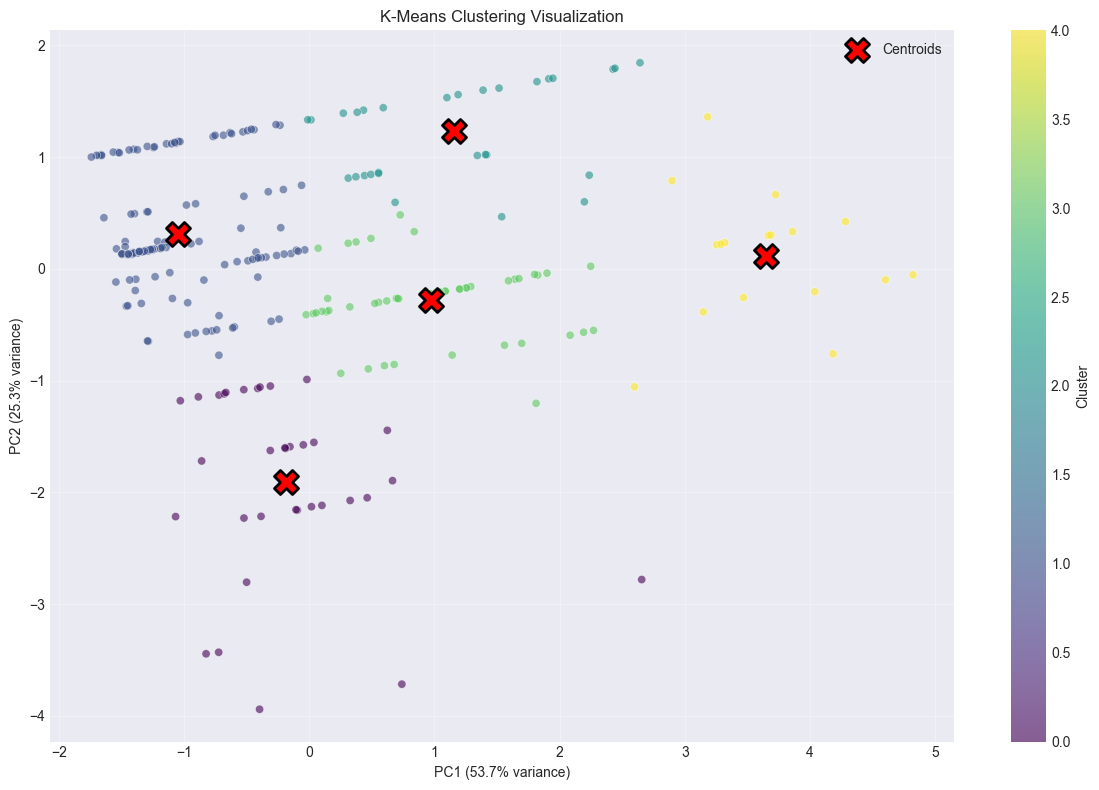

In [19]:
# Visualize clusters
clusterer.visualize_clusters_2d(features, labels)

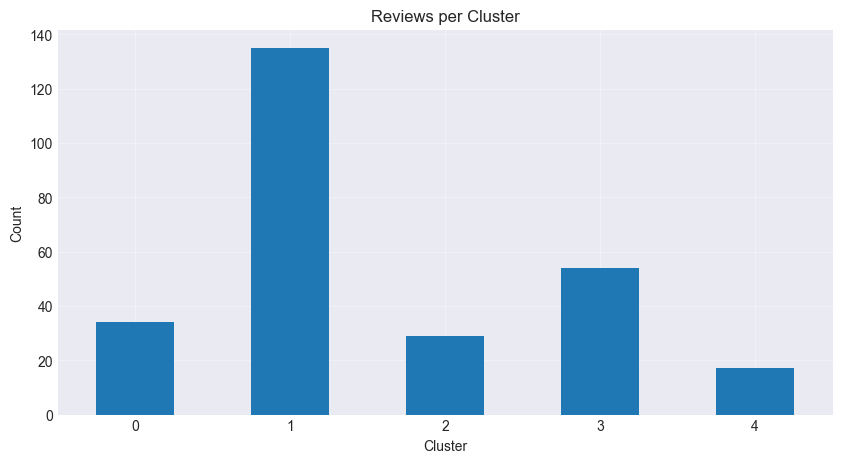

In [20]:
# Cluster distribution
cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(10, 5))
cluster_counts.plot(kind='bar')
plt.title('Reviews per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Cluster summary
summary = clusterer.get_cluster_summary(
    df_cluster,
    labels,
    numeric_columns=['text_length', 'word_count', 'score']
)

print("\n=== Cluster Summary ===")
display(summary)


=== Cluster Summary ===


text_length                    word_count                      score  \
                mean         std count        mean        std count      mean   
cluster                                                                         
0         657.911765  431.427326    34  110.029412  75.724975    34  4.452941   
1         372.955556  302.919029   135   63.022222  50.299471   135  8.582222   
2        1917.344828  528.660996    29  328.965517  97.123442    29  9.444828   
3        1609.722222  402.947041    54  273.777778  72.673129    54  6.898148   
4        3450.411765  360.948067    17  578.235294  77.803060    17  6.694118   

                         
              std count  
cluster                  
0        1.478172    34  
1        0.917806   135  
2        0.678015    29  
3        0.616898    54  
4        1.024372    17

## 6. Statistical Tests

In [22]:
# ANOVA: Score differences across clusters
cluster_groups = []
for i in range(optimal_k):
    cluster_scores = df_cluster[labels == i]['score'].dropna()
    cluster_groups.append(cluster_scores)

f_stat, p_value = stats.f_oneway(*cluster_groups)

print("\n=== ANOVA: Score across Clusters ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant: {'Yes (p < 0.05)' if p_value < 0.05 else 'No (p >= 0.05)'}")

TypeError: unsupported operand type(s) for *: 'float' and 'decimal.Decimal'

In [23]:
# Chi-squared: Sentiment vs Cluster
contingency = pd.crosstab(labels, df_cluster['sentiment'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print("\n=== Chi-squared: Sentiment vs Cluster ===")
print(f"Chi² statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Significant: {'Yes (p < 0.05)' if p_value < 0.05 else 'No (p >= 0.05)'}")

print("\nContingency Table:")
display(contingency)


=== Chi-squared: Sentiment vs Cluster ===
Chi² statistic: 218.9214
p-value: 0.0000
Degrees of freedom: 8
Significant: Yes (p < 0.05)

Contingency Table:


sentiment,negative,neutral,positive
row_0,,,
0,24,10,0
1,0,1,134
2,0,0,29
3,1,10,43
4,2,5,10


In [24]:
# Correlation: Text length vs Score
valid_data = df_cluster[['text_length', 'score']].dropna()
corr, p_value = stats.pearsonr(valid_data['text_length'], valid_data['score'])

print("\n=== Correlation: Text Length vs Score ===")
print(f"Pearson correlation: {corr:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant: {'Yes (p < 0.05)' if p_value < 0.05 else 'No (p >= 0.05)'}")

AttributeError: 'numpy.dtypes.ObjectDType' object has no attribute 'dtype'

## 7. Save Models

In [25]:
# Save trained models
import os

os.makedirs('../models', exist_ok=True)

# Save sentiment classifier
classifier.save_model('../models/sentiment_classifier')
print("✓ Sentiment classifier saved")

# Save score predictor
predictor.save_model('../models/score_predictor')
print("✓ Score predictor saved")

INFO:src.models.sentiment_classifier:Model saved to ..\models\sentiment_classifier.model.pkl


INFO:src.models.sentiment_classifier:Vectorizer saved to ..\models\sentiment_classifier.vectorizer.pkl


INFO:src.models.score_predictor:Model saved to ..\models\score_predictor.model.pkl


✓ Sentiment classifier saved
✓ Score predictor saved


## 8. Summary

In [26]:
print("\n" + "="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Dataset:")
print(f"  Total reviews: {len(df_labeled)}")
print(f"  Train samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

print(f"\n🎯 Sentiment Classification:")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")

print(f"\n📈 Score Prediction:")
test_reg_metrics = predictor.evaluate(X_text_test, y_score_test, X_meta_test)
print(f"  R² Score: {test_reg_metrics['r2']:.4f}")
print(f"  RMSE: {test_reg_metrics['rmse']:.4f}")
print(f"  MAE: {test_reg_metrics['mae']:.4f}")

print(f"\n🔍 Clustering:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette Score: {metrics['silhouette_score']:.4f}")

print(f"\n✅ Models saved to: ../models/")
print("="*60)


MODEL TRAINING SUMMARY

📊 Dataset:
  Total reviews: 269
  Train samples: 215
  Test samples: 54

🎯 Sentiment Classification:


KeyError: 'accuracy'